In [ ]:
#https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/multi_agent/agent_supervisor.md

In [35]:
!dir

 El volumen de la unidad C no tiene etiqueta.
 El n�mero de serie del volumen es: 647B-0096

 Directorio de c:\Users\jdmartinev\OneDrive - Universidad EAFIT\Cursos\Inteligencia Artificial - IM\Info\Lecture13

27/10/2025  04:32 p.�m.    <DIR>          .
27/10/2025  01:41 p.�m.    <DIR>          ..
27/10/2025  01:54 p.�m.               303 .env
27/10/2025  03:39 p.�m.    <DIR>          agents
27/10/2025  04:17 p.�m.            27.684 agent_supervisor.md
27/10/2025  04:32 p.�m.    <DIR>          assets
27/10/2025  04:34 p.�m.           129.739 multi-agent-langgraph.ipynb
27/10/2025  04:20 p.�m.            36.087 multi_agent.md
               4 archivos        193.813 bytes
               4 dirs  262.054.182.912 bytes libres


# Multi-agent supervisor

[**Supervisor**](https://github.com/langchain-ai/langgraph/blob/main/docs/docs/concepts/multi_agent.md#supervisor) is a multi-agent architecture where **specialized** agents are coordinated by a central **supervisor agent**. The supervisor agent controls all communication flow and task delegation, making decisions about which agent to invoke based on the current context and task requirements.

In this tutorial, you will build a supervisor system with two agents — a research and a math expert. By the end of the tutorial you will:

1. Build specialized research and math agents
2. Build a supervisor for orchestrating them with the prebuilt [`langgraph-supervisor`](https://langchain-ai.github.io/langgraph/agents/multi-agent/#supervisor)
3. Build a supervisor from scratch
4. Implement advanced task delegation

![diagram](assets\diagram.png)


## Setup

First, let's install required packages and set our API keys

```python
%%capture --no-stderr
%pip install -U langgraph langgraph-supervisor langchain-tavily langchain-google-genai
```

!!! tip
    Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. [LangSmith](https://docs.smith.langchain.com) lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph.

In [10]:
import os
from dotenv import load_dotenv
_ = load_dotenv(".env")

## 1. Create worker agents

First, let's create our specialized worker agents — research agent and math agent:

* Research agent will have access to a web search tool using [Tavily API](https://tavily.com/)
* Math agent will have access to simple math tools (`add`, `multiply`, `divide`)

### Research agent

For web search, we will use `TavilySearch` tool from `langchain-tavily`:

In [11]:
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)
web_search_results = web_search.invoke("who is the mayor of NYC?")
print(web_search_results["results"][0]["content"])

[Skip to main content](https://www.nyc.gov/mayors-office/mayors-bio#mainContent) *   [Services](https://www.nyc.gov/main/services) *   [View all services](https://www.nyc.gov/main/services) *   [Events](https://www.nyc.gov/main/events) *   [Office of the Mayor](https://www.nyc.gov/mayors-office) *   [Your government](https://www.nyc.gov/main/your-government) *   [Understanding local government](https://www.nyc.gov/main/your-government) *   [nyc.gov home](https://www.nyc.gov/main) [NYC](https://www.nyc.gov/) [NYC](https://www.nyc.gov/) [Office of the Mayor](https://www.nyc.gov/mayors-office) *   [News](https://www.nyc.gov/mayors-office/news) *   [Contact the Mayor](https://www.nyc.gov/mayors-office/contact-the-mayor) *   [Biography](https://www.nyc.gov/mayors-office/mayors-bio) [Contact the Mayor](https://www.nyc.gov/mayors-office/contact-the-mayor) ![Image 2](https://www.nyc.gov/adobe/dynamicmedia/deliver/dm-aid--052e534c-1b88-4f18-835e-49b66126c154/mayors-bio-crop-jpg.webp?preferwebp=

To create individual worker agents, we will use LangGraph's prebuilt [agent](https://github.com/langchain-ai/langgraph/blob/main/docs/docs/agents/agents.md).

In [13]:
from langgraph.prebuilt import create_react_agent
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model= "gemini-2.5-flash",
    temperature=1.0,
    max_retries=2,
    google_api_key=os.environ.get("GOOGLE_API_KEY"),
)  #reduce inference cost


research_agent = create_react_agent(
    model=llm,
    tools=[web_search],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="research_agent",
)

C:\Users\jdmartinev\AppData\Local\Temp\ipykernel_24212\966641711.py:12: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  research_agent = create_react_agent(


Let's [run the agent](https://github.com/langchain-ai/langgraph/blob/main/docs/docs/agents/run_agents.md) to verify that it behaves as expected. 

!!! note "We'll use `pretty_print_messages` helper to render the streamed agent outputs nicely"


In [14]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [15]:
for chunk in research_agent.stream(
    {"messages": [{"role": "user", "content": "who is the mayor of NYC?"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  tavily_search (70e3e8ef-dcdc-4dfa-ac1a-5298f9305ad3)
 Call ID: 70e3e8ef-dcdc-4dfa-ac1a-5298f9305ad3
  Args:
    query: mayor of NYC


Update from node tools:


================================= Tool Message =================================
Name: tavily_search

{"query": "mayor of NYC", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.nyc.gov/mayors-office/mayors-bio", "title": "Biography - NYC Mayor's Office", "content": "[Skip to main content](https://www.nyc.gov/mayors-office/mayors-bio#mainContent) *   [Services](https://www.nyc.gov/main/services) *   [View all services](https://www.nyc.gov/main/services) *   [Events](https://www.nyc.gov/main/events) *   [Office of the Mayor](https://www.nyc.gov/mayors-office) *   [Your government](https://www.nyc.gov/main/your-government) *   [Understanding local go

### Math agent

For math agent tools we will use [vanilla Python functions](https://github.com/langchain-ai/langgraph/blob/main/docs/docs/how-tos/tool-calling.md#define-a-tool):

In [17]:
def add(a: float, b: float):
    """Add two numbers."""
    return a + b


def multiply(a: float, b: float):
    """Multiply two numbers."""
    return a * b


def divide(a: float, b: float):
    """Divide two numbers."""
    return a / b


math_agent = create_react_agent(
    model=llm,
    tools=[add, multiply, divide],
    prompt=(
        "You are a math agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with math-related tasks\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="math_agent",
)

C:\Users\jdmartinev\AppData\Local\Temp\ipykernel_24212\2730518903.py:16: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  math_agent = create_react_agent(


Let's run the math agent:

In [18]:
for chunk in math_agent.stream(
    {"messages": [{"role": "user", "content": "what's (3 + 5) x 7"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  add (55f814d1-c762-414f-9e92-30abbf8faeeb)
 Call ID: 55f814d1-c762-414f-9e92-30abbf8faeeb
  Args:
    a: 3
    b: 5


Update from node tools:


================================= Tool Message =================================
Name: add

8.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  multiply (bfb7a1b5-6d23-4226-9c8c-e73f62233b3a)
 Call ID: bfb7a1b5-6d23-4226-9c8c-e73f62233b3a
  Args:
    a: 8
    b: 7


Update from node tools:


================================= Tool Message =================================
Name: multiply

56.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent

56




## 2. Create supervisor with `langgraph-supervisor`

To implement out multi-agent system, we will use @[`create_supervisor`][create_supervisor] from the prebuilt `langgraph-supervisor` library:

In [20]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model=llm,
    agents=[research_agent, math_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()

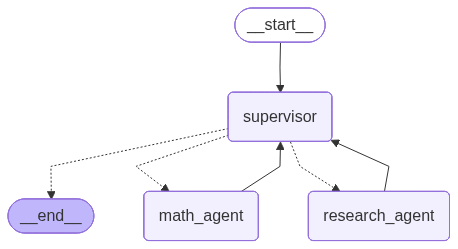

In [21]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

**Note:** When you run this code, it will generate and display a visual representation of the supervisor graph showing the flow between the supervisor and worker agents.

Let's now run it with a query that requires both agents:

* research agent will look up the necessary GDP information
* math agent will perform division to find the percentage of NY state GDP, as requested

In [22]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "find US and New York state GDP in 2024. what % of US GDP was New York state?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

The US GDP in 2024 is approximately $27.94 trillion. New York state's GDP in 2024 is approximately $2.3 trillion.

New York state's GDP is about 8.23% of the US GDP.




## 3. Create supervisor from scratch

Let's now implement this same multi-agent system from scratch. We will need to:

1. [Set up how the supervisor communicates](#set-up-agent-communication) with individual agents
2. [Create the supervisor agent](#create-supervisor-agent)
3. Combine supervisor and worker agents into a [single multi-agent graph](#create-multi-agent-graph).

### Set up agent communication

We will need to define a way for the supervisor agent to communicate with the worker agents. A common way to implement this in multi-agent architectures is using **handoffs**, where one agent *hands off* control to another. Handoffs allow you to specify:

- **destination**: target agent to transfer to
- **payload**: information to pass to that agent

We will implement handoffs via **handoff tools** and give these tools to the supervisor agent: when the supervisor calls these tools, it will hand off control to a worker agent, passing the full message history to that agent.

In [23]:
from typing import Annotated
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.types import Command


def create_handoff_tool(*, agent_name: str, description: str | None = None):
    name = f"transfer_to_{agent_name}"
    description = description or f"Ask {agent_name} for help."

    @tool(name, description=description)
    def handoff_tool(
        state: Annotated[MessagesState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ) -> Command:
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": name,
            "tool_call_id": tool_call_id,
        }
        # highlight-next-line
        return Command(
            # highlight-next-line
            goto=agent_name,  # (1)!
            # highlight-next-line
            update={**state, "messages": state["messages"] + [tool_message]},  # (2)!
            # highlight-next-line
            graph=Command.PARENT,  # (3)!
        )

    return handoff_tool


# Handoffs
assign_to_research_agent = create_handoff_tool(
    agent_name="research_agent",
    description="Assign task to a researcher agent.",
)

assign_to_math_agent = create_handoff_tool(
    agent_name="math_agent",
    description="Assign task to a math agent.",
)

1. Name of the agent or node to hand off to.
2. Take the agent's messages and add them to the parent's state as part of the handoff. The next agent will see the parent state.
3. Indicate to LangGraph that we need to navigate to agent node in a **parent** multi-agent graph.

### Create supervisor agent

Then, let's create the supervisor agent with the handoff tools we just defined. We will use the prebuilt @[`create_react_agent`][create_react_agent]:

In [24]:
supervisor_agent = create_react_agent(
    model=llm,
    tools=[assign_to_research_agent, assign_to_math_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    name="supervisor",
)

C:\Users\jdmartinev\AppData\Local\Temp\ipykernel_24212\1869430543.py:1: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  supervisor_agent = create_react_agent(


### Create multi-agent graph

Putting this all together, let's create a graph for our overall multi-agent system. We will add the supervisor and the individual agents as subgraph [nodes](https://github.com/langchain-ai/langgraph/blob/main/docs/docs/concepts/low_level.md#nodes).

In [25]:
from langgraph.graph import END

# Define the multi-agent supervisor graph
supervisor = (
    StateGraph(MessagesState)
    # NOTE: `destinations` is only needed for visualization and doesn't affect runtime behavior
    .add_node(supervisor_agent, destinations=("research_agent", "math_agent", END))
    .add_node(research_agent)
    .add_node(math_agent)
    .add_edge(START, "supervisor")
    # always return back to the supervisor
    .add_edge("research_agent", "supervisor")
    .add_edge("math_agent", "supervisor")
    .compile()
)

Notice that we've added explicit [edges]((https://github.com/langchain-ai/langgraph/blob/main/docs/docs/concepts/low_level.md#edges) from worker agents back to the supervisor — this means that they are guaranteed to return control back to the supervisor. If you want the agents to respond directly to the user (i.e., turn the system into a router, you can remove these edges).

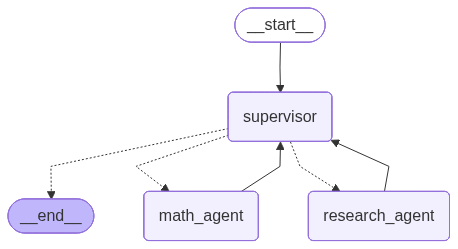

In [26]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

**Note:** When you run this code, it will generate and display a visual representation of the multi-agent supervisor graph showing the flow between the supervisor and worker agents.

With the multi-agent graph created, let's now run it!


In [27]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "find US and New York state GDP in 2024. what % of US GDP was New York state?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================== Ai Message ==================================
Name: research_agent

The estimated US GDP for 2024 is $29.184 trillion, while New York state's GDP for 2024 is estimated to be around $2.30 trillion.

To calculate the percentage of US GDP that New York state represents, we divide New York's GDP by the US GDP and multiply by 100:

($2.30 trillion / $29.184 trillion) * 100 = 7.88%

Therefore, New York state's GDP is approximately 7.88% of the total US GDP in 2024.


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_math_agent

Successfully transferred to math_agent


Update from node math_agent:


================================== Ai Message =============

Let's examine the full resulting message history:

In [28]:
for message in final_message_history:
    message.pretty_print()

================================ Human Message =================================

find US and New York state GDP in 2024. what % of US GDP was New York state?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_research_agent (43027ea4-3fcf-4109-b2bc-d45d3c924251)
 Call ID: 43027ea4-3fcf-4109-b2bc-d45d3c924251
  Args:
================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent
================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  tavily_search (afb32888-8bdc-4e04-8519-20bfcf6cc8d2)
 Call ID: afb32888-8bdc-4e04-8519-20bfcf6cc8d2
  Args:
    query: US GDP 2024 estimate
  tavily_search (56384156-11c0-4462-b238-0a6d3cfa9618)
 Call ID: 56384156-11c0-4462-b238-0a6d3cfa9618
  Args:
    query: New York state GDP 2024 estimate
================================= Tool M

## 4. Create delegation tasks

So far the individual agents relied on **interpreting full message history** to determine their tasks. An alternative approach is to ask the supervisor to **formulate a task explicitly**. We can do so by adding a `task_description` parameter to the `handoff_tool` function.


In [30]:
from langgraph.types import Send


def create_task_description_handoff_tool(
    *, agent_name: str, description: str | None = None
):
    name = f"transfer_to_{agent_name}"
    description = description or f"Ask {agent_name} for help."

    @tool(name, description=description)
    def handoff_tool(
        # this is populated by the supervisor LLM
        task_description: Annotated[
            str,
            "Description of what the next agent should do, including all of the relevant context.",
        ],
        # these parameters are ignored by the LLM
        state: Annotated[MessagesState, InjectedState],
    ) -> Command:
        task_description_message = {"role": "user", "content": task_description}
        agent_input = {**state, "messages": [task_description_message]}
        return Command(
            # highlight-next-line
            goto=[Send(agent_name, agent_input)],
            graph=Command.PARENT,
        )

    return handoff_tool


assign_to_research_agent_with_description = create_task_description_handoff_tool(
    agent_name="research_agent",
    description="Assign task to a researcher agent.",
)

assign_to_math_agent_with_description = create_task_description_handoff_tool(
    agent_name="math_agent",
    description="Assign task to a math agent.",
)

supervisor_agent_with_description = create_react_agent(
    model=llm,
    tools=[
        assign_to_research_agent_with_description,
        assign_to_math_agent_with_description,
    ],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this assistant\n"
        "- a math agent. Assign math-related tasks to this assistant\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    name="supervisor",
)

supervisor_with_description = (
    StateGraph(MessagesState)
    .add_node(
        supervisor_agent_with_description, destinations=("research_agent", "math_agent")
    )
    .add_node(research_agent)
    .add_node(math_agent)
    .add_edge(START, "supervisor")
    .add_edge("research_agent", "supervisor")
    .add_edge("math_agent", "supervisor")
    .compile()
)

C:\Users\jdmartinev\AppData\Local\Temp\ipykernel_24212\3354595730.py:41: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  supervisor_agent_with_description = create_react_agent(


!!! note
    We're using @[`Send()`][Send] primitive in the `handoff_tool`. This means that instead of receiving the full `supervisor` graph state as input, each worker agent only sees the contents of the `Send` payload. In this example, we're sending the task description as a single "human" message.


Let's now running it with the same input query:

In [31]:
for chunk in supervisor_with_description.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "find US and New York state GDP in 2024. what % of US GDP was New York state?",
            }
        ]
    },
    subgraphs=True,
):
    pretty_print_messages(chunk, last_message=True)

Update from subgraph supervisor:


	Update from node agent:


	================================== Ai Message ==================================
	Name: supervisor
	Tool Calls:
	  transfer_to_research_agent (3104b1d0-73d8-4894-bc3a-27aeace9edd3)
	 Call ID: 3104b1d0-73d8-4894-bc3a-27aeace9edd3
	  Args:
	    task_description: Find the US GDP for 2024 and the New York state GDP for 2024. Then, calculate what percentage of the US GDP the New York state GDP represents.


Update from subgraph research_agent:


	Update from node agent:


	================================== Ai Message ==================================
	Name: research_agent
	Tool Calls:
	  tavily_search (b597abb9-c10f-47a6-aceb-15fd93a7742c)
	 Call ID: b597abb9-c10f-47a6-aceb-15fd93a7742c
	  Args:
	    query: US GDP 2024
	  tavily_search (03f83f62-da52-4a42-896a-cfb57183da47)
	 Call ID: 03f83f62-da52-4a42-896a-cfb57183da47
	  Args:
	    query: New York state GDP 2024


Update from subgraph research_agent:


	Update from node too